# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [2]:
from unityagents import UnityEnvironment
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import numpy as np
import torch
import time

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis_Linux/Tennis.x86")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


When finished, you can close the environment.

### 4. Initialize the Agents

In [5]:
from multi_ddpg_agent import *
# initialize agents
agent_one = Agent(state_size, action_size, random_seed=42)
agent_two = Agent(state_size, action_size, random_seed=42)

In [6]:
def multi_ddpg(n_episodes=5000, max_t=2000, threshold=0.5):

    scores_total = []
    scores_deque = deque(maxlen=100)
    scores_final = []
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        # flatten states
        states = np.reshape(env_info.vector_observations, (1,48)) 
        agent_one.reset()                                       
        agent_two.reset()
        scores = np.zeros(num_agents)
        
        for t in range(max_t):
            # each agent takes actions
            action_alpha = agent_one.act(states)                                    
            action_beta = agent_two.act(states)
            # join the actions from both agents and reshape
            actions = np.concatenate((action_alpha, action_beta), axis=0).flatten()
            # send actions from both agents to the environment
            env_info = env.step(actions)[brain_name]
            # flatten next states
            next_states = np.reshape(env_info.vector_observations, (1,48))
            rewards = env_info.rewards
            done = env_info.local_done
            
            agent_one.step(states, actions, rewards[0], next_states, done, 0)
            agent_two.step(states, actions, rewards[1], next_states, done, 1)
            
            states = next_states
            scores += np.max(rewards)    
            
            if np.any(done):
                break 
        
        # mean score on 2 agents
        mean_score = np.mean(scores)
        scores_total.append(mean_score)
        # mean score on 2 agents for 100 episodes
        scores_deque.append(mean_score)
        # mean score overall for 100 episodes
        avg_score = np.mean(scores_deque)
        scores_final.append(avg_score)
        
         # printing statistics
        if i_episode % 100 == 0:
            print('Episode: {}, Score: {:.4f}, \tAVG Score: {:.4f}'.format(i_episode, mean_score, avg_score))

        if avg_score > threshold:
            print('\nEnvironment succesfully solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, avg_score))
            
            torch.save(agent_one.actor_local.state_dict(), 'checkpoint_actor_one.pth')
            torch.save(agent_one.critic_local.state_dict(), 'checkpoint_critic_one.pth')
            torch.save(agent_two.actor_local.state_dict(), 'checkpoint_actor_two.pth')
            torch.save(agent_two.critic_local.state_dict(), 'checkpoint_critic_two.pth')
            
            break
                
    return scores_total, scores_final

## 5. Training



In [5]:
scores_total, scores_final = multi_ddpg()

Training Started...........
Episode: 100, Score: 0.0000, 	AVG Score: 0.0090
Episode: 200, Score: 0.0000, 	AVG Score: 0.0290
Episode: 300, Score: 0.2000, 	AVG Score: 0.0890
Episode: 400, Score: 0.2000, 	AVG Score: 0.0870
Episode: 500, Score: 0.1000, 	AVG Score: 0.1410
Episode: 600, Score: 0.1000, 	AVG Score: 0.1860
Episode: 700, Score: 0.1000, 	AVG Score: 0.1710
Episode: 800, Score: 1.0000, 	AVG Score: 0.2960

Environment succesfully solved in 892 episodes!	Average Score: 0.51



In [3]:
scores_total = np.load('scores_total.npy')
scores_final = np.load('scores_final.npy')

## 6. Plots

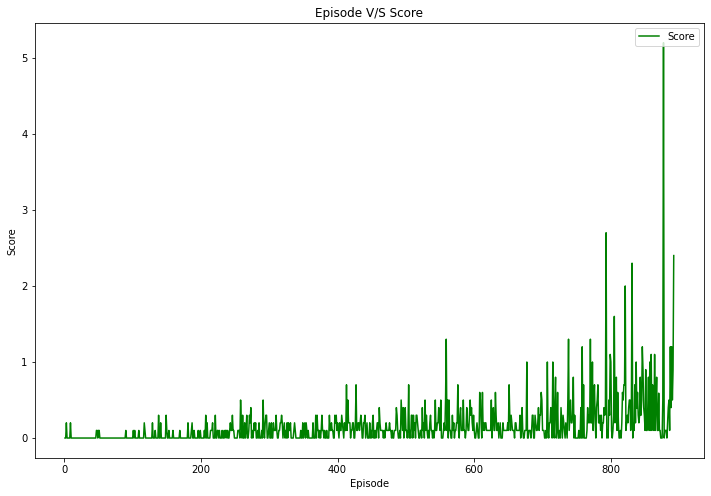

In [5]:
fig = plt.figure(figsize=[12,8])
ax = fig.add_subplot(111)

plt.plot(np.arange(1, len(scores_total)+1), scores_total, 'g', label='Score')
plt.ylabel('Score')
plt.xlabel('Episode')
plt.title('Episode V/S Score')
plt.legend(loc='upper right');
plt.show()